# Time Series: Forecasting stockprice for Amazon

On repart sur des bases saines et on va y aller pas à pas de façon structuré

In [332]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, SimpleRNN
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
import missingno as msno

### Data Engineering et visualisation

In [ ]:
df=pd.read_csv("AMZN_2006-01-01_to_2018-01-01.csv",index_col="Date", parse_dates=['Date'])

In [81]:
df_simple = df.copy()

In [82]:
df_simple

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN
2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN
2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN
2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN
2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN
...,...,...,...,...,...,...
2017-12-22,1172.08,1174.62,1167.83,1168.36,1585054,AMZN
2017-12-26,1168.36,1178.32,1160.55,1176.76,2005187,AMZN
2017-12-27,1179.91,1187.29,1175.61,1182.26,1867208,AMZN


<AxesSubplot:>

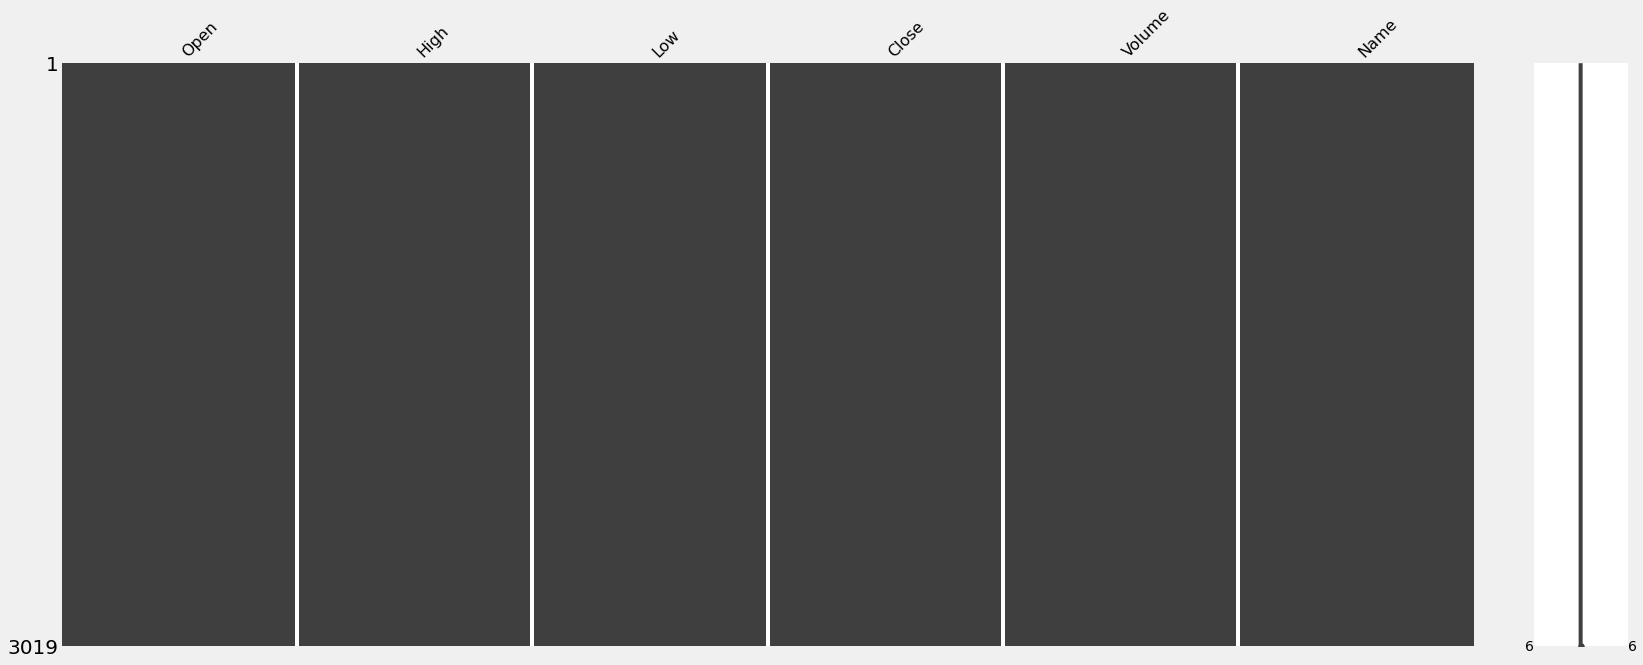

In [333]:
msno.matrix(df)

Text(0.5, 1.0, 'Amazon stock price')

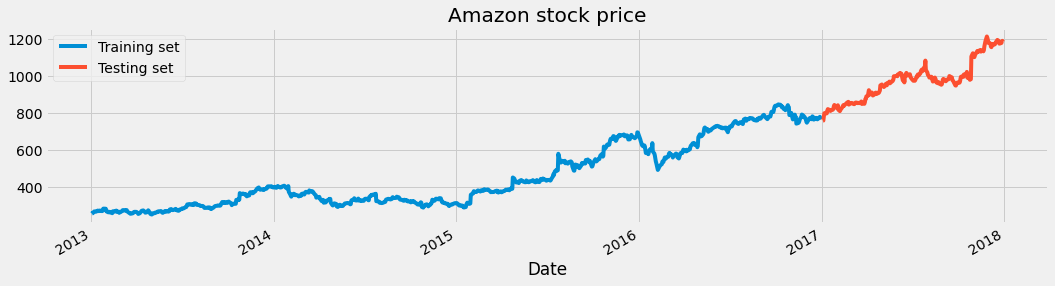

In [328]:
#Visualisation trainin_set et testing_set
df_simple["2013":"2016"].High.plot(figsize=(16,4), legend=True)
df_simple["2017":].High.plot(figsize=(16,4), legend=True)
plt.legend(["Training set","Testing set"])
plt.title('Amazon stock price')

Text(0.5, 1.0, 'Amazon stock price 3 mois')

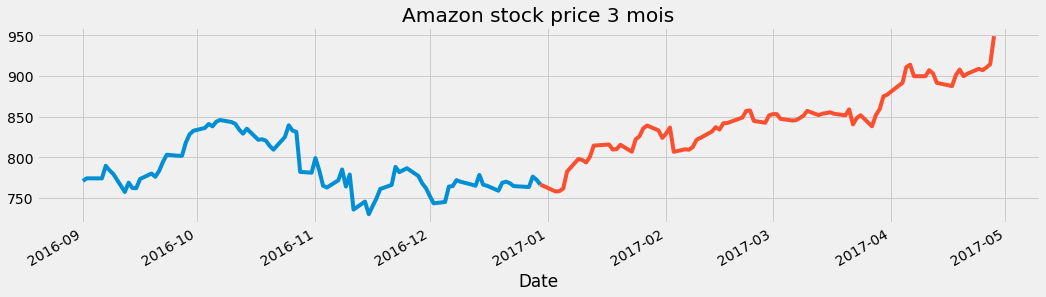

In [329]:
#Visualisation sur 3 mois
df["2016-09":"2016-12-31"].High.plot(figsize=(16,4))
df["2016-12-30":"2017-04"].High.plot(figsize=(16,4))
plt.title('Amazon stock price 3 mois')

Text(0.5, 1.0, 'Amazon stock price 3 mois')

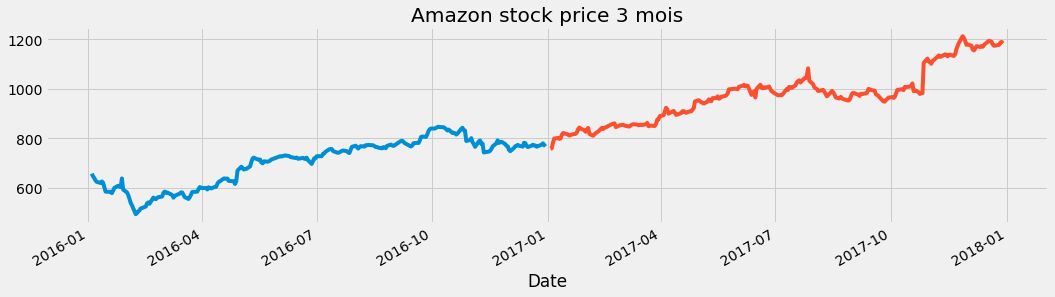

In [367]:
df["2016"].High.plot(figsize=(16,4))
df["2017"].High.plot(figsize=(16,4))
plt.title('Amazon stock price 3 mois')

Text(0.5, 1.0, 'Amazon stock price 1 mois')

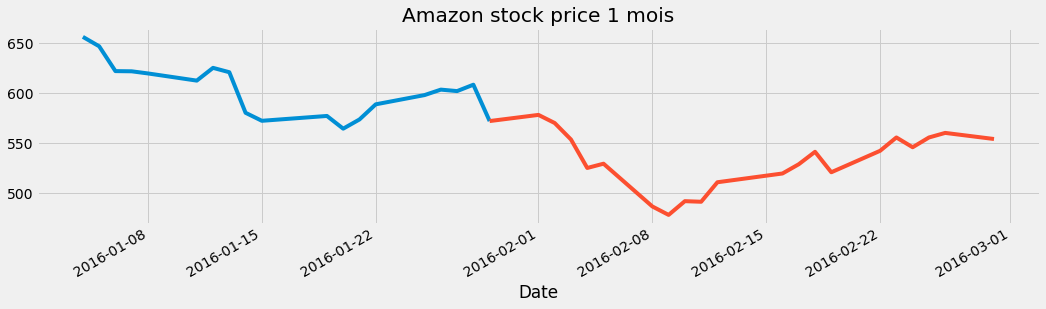

In [330]:
#Visualisation sur 1 mois
df["2016-01-01":"2016-01-31"].High.plot(figsize=(16,4))
df["2016-01-29":'2016-02'].High.plot(figsize=(16,4))
plt.title("Amazon stock price 1 mois")

Text(0.5, 1.0, 'Amazon stock price 15 jours')

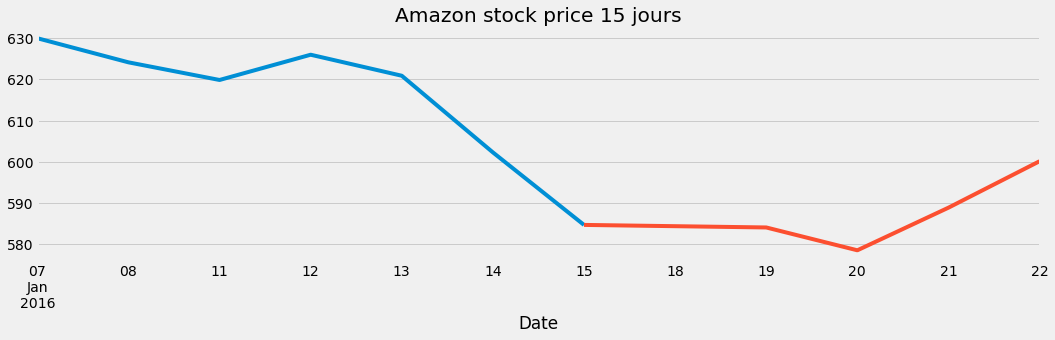

In [338]:
#Visualisation sur 1 mois
df["2016-01-07":"2016-01-15"].High.plot(figsize=(16,4))
df["2016-01-15":'2016-01-22'].High.plot(figsize=(16,4))
plt.title("Amazon stock price 15 jours")

On sépare nos données en deux de 2006 à 2016 pour le train et de 2017 à 2018 pour le test

In [361]:
training_set = df_simple[:'2016'].iloc[:,1:2].values
test_set = df_simple['2017':].iloc[:,1:2].values

In [229]:
test_set.shape

(251, 1)

Fonction pour split nos données. A noter qu'on ne peut pas split nos données de manière classique étant donné qu'on ne veux en aucun cas shuffle nos données. De plus la séparation target est particulière ici.

In [257]:
#La fonction prend en argument :
#Le dataframe d'où proviennent les données
#La variable qu'on va prédire
#Le train et le test qu'on a déjà séparé
#Time une variable que l'on fixe elle représente le temps que l'on va utiliser pour prédire chaque variable T



def split_time_series(df,var,train_set,test_set,time):
    '''
    Return: X_train,X_test,y_train,test_set, sc

    '''
    #On scale nos données car les Réseau de neurone les supporte mieux ainsi.
    sc=MinMaxScaler(feature_range=(0,1))
    tss=sc.fit_transform(train_set)
    
    #On va créer d'abords deux variable d'entrainement des listes X_train et y_train
    X_train=[]
    y_train=[]
    
    #Avec une boucle on va parcourir la range qui va de Time à la taille de notre train_set
    for i in range(time,train_set.shape[0]):
        #X_train va recevoir à chaque itération de la boucle les valeurs allant de i-time à i
        X_train.append(tss[i-time:i,0])
        #X_train va recevoir à chaque itération de la boucle la valeur de i 
        #(Que l'on voudra prédire avec le X_train associer)
        y_train.append(tss[i,0])
    
    #On obtiens alors deux listes un X_train de deux dimension et un y_train de une dimension.
    #On les transforme en numpy array afin de pouvoir les manipuler par la suite et les entrer
    #Dans un model
    X_train=np.array(X_train)
    y_train=np.array(y_train)
    
    #Note: Les shapes de nos array sont égales à X_train [test_set.shape[0]-time, time]
    #      y_train : [test_set.shape[0]-time]
    
    #Pour coller aux norme Tensors et bien faire comprendre au modèle qu'on est dans le cas d'une
    #série temporelle on ajoute une troisième dimension égal à 1 (Qui existe mais a été enlever par numpy) 
    
    #Ici j'ajoute une condition afin que ma fonction marche dans le cas d'une prediction multivarié
    if X_train.ndim<3:
        X_train = np.reshape(np.array(X_train),(X_train.shape[0],X_train.shape[1],1))
    
    
    #On va maintenant appliqué le même procédé sur le test avec une petite étape préalable 
    X_test=[]
    
    #On veut prédire dés l'instant T0 de notre test du coup il faut utiliser des valeurs prise 
    #dans les données de test pour prédire nos "time" première valeurs
    inputs= df[var][len(df)-len(test_set) - time:].values
    inputs= inputs.reshape(-1,1)
    inputs= sc.transform(inputs)
    
    #Même choses pour le train
    for i in range(time,inputs.shape[0]):
        X_test.append(inputs[i-time:i,0])
    X_test = np.array(X_test)
    
    if X_test.ndim<3:
        X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))    
    print(inputs.shape)
    return X_train,X_test,y_train,test_set, sc
#Note on retourne sc afin de garder une trace et pour voir retransformer nos données scaled en donnée
#Réelle. 

## Amplitude de temps = 30 jours

In [233]:
X_train,X_test,y_train,test_set,sc= split_time_series(df_simple,"High",training_set,test_set,30)

(281, 1)


In [206]:
training_set.shape

(2768, 1)

In [158]:
X_train.shape

(2738, 30, 1)

In [159]:
X_test.shape

(251, 30, 1)

In [160]:
y_train.shape

(2738,)

In [161]:
test_set.shape

(251, 1)

Notre méthodologie d'évaluation des modeles 

In [339]:
def validation_curve(hist):

    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'Validation'], loc='upper left')
    plt.show()
    
def plot_predictions(test,predicted, describe):
    plt.plot(test, color='red',label='Real Amzon Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Amazon Stock Price',ls=":",lw=2.5)
    plt.title(f'Amazon Stock Price Prediction\nParameters : {describe}')
    plt.xlabel('Time')
    plt.ylabel('Amazon Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

### Model simple: 1 couche LSTM de 8 neurone et 1 couche d'output 

Note : Pour l'ensemble des modèles nous allons (Pour l'instant) garder les mêmes paramètres de compilation et de fit.

Le seul paramètres a avoir été modifié a été le nombre d'epochs passant de 50 à 150 celà a été fait après observation de la validation_curve nous montrant une possibilité d'amélioration avec le temps. 

In [180]:
model=Sequential()

model.add(LSTM(units=8))
model.add(Dense(units=1))

model.compile(optimizer='adam',loss='mean_squared_error')

In [181]:
history=model.fit(X_train,y_train, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
60/60 [==============================] - 3s 56ms/step - loss: 0.0111 - val_loss: 0.0886
Epoch 2/150
60/60 [==============================] - 2s 27ms/step - loss: 0.0024 - val_loss: 8.8061e-04
Epoch 3/150
60/60 [==============================] - 2s 27ms/step - loss: 1.5261e-04 - val_loss: 0.0028
Epoch 4/150
60/60 [==============================] - 2s 28ms/step - loss: 9.9171e-05 - val_loss: 0.0017
Epoch 5/150
60/60 [==============================] - 2s 28ms/step - loss: 8.4713e-05 - val_loss: 0.0012
Epoch 6/150
60/60 [==============================] - 2s 29ms/step - loss: 7.4608e-05 - val_loss: 0.0012
Epoch 7/150
60/60 [==============================] - 2s 28ms/step - loss: 6.5458e-05 - val_loss: 0.0015
Epoch 8/150
60/60 [==============================] - 2s 30ms/step - loss: 6.0806e-05 - val_loss: 0.0021
Epoch 9/150
60/60 [==============================] - 2s 31ms/step - loss: 5.5257e-05 - val_loss: 0.0028
Epoch 10/150
60/60 [==============================] - 2s 29ms/step -

Epoch 77/150
60/60 [==============================] - 2s 32ms/step - loss: 3.1309e-05 - val_loss: 2.2479e-04
Epoch 78/150
60/60 [==============================] - 2s 32ms/step - loss: 2.8747e-05 - val_loss: 2.1888e-04
Epoch 79/150
60/60 [==============================] - 2s 31ms/step - loss: 2.8133e-05 - val_loss: 2.1699e-04
Epoch 80/150
60/60 [==============================] - 2s 30ms/step - loss: 2.9901e-05 - val_loss: 2.4076e-04
Epoch 81/150
60/60 [==============================] - 2s 32ms/step - loss: 2.8230e-05 - val_loss: 2.1077e-04
Epoch 82/150
60/60 [==============================] - 2s 30ms/step - loss: 2.7574e-05 - val_loss: 2.1015e-04
Epoch 83/150
60/60 [==============================] - 2s 31ms/step - loss: 2.8626e-05 - val_loss: 2.0483e-04
Epoch 84/150
60/60 [==============================] - 2s 32ms/step - loss: 2.8096e-05 - val_loss: 2.0441e-04
Epoch 85/150
60/60 [==============================] - 2s 31ms/step - loss: 2.6967e-05 - val_loss: 2.2652e-04
Epoch 86/150
60/60 

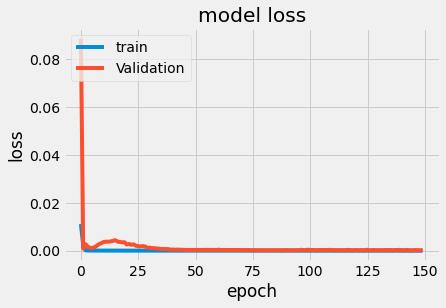

In [366]:
validation_curve(history)

In [183]:
predicted_stock_price_scale = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price_scale)

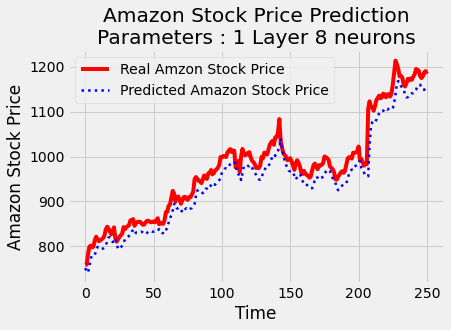

In [340]:
plot_predictions(test_set,predicted_stock_price, "1 Layer 8 neurons")

In [190]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 31.48834413102283.


#### Conclusion
C'est déjà un bon premier modèle (étonnamment) mais poursuivons pour essayer de l'amélioré en complexifiant l'architecture. 

### Model 2 : 3 layers de LSTM avec 8 neurones et 1 couche d'output

In [185]:
model2=Sequential()

model2.add(LSTM(units=8, return_sequences=True))
model2.add(LSTM(units=8, return_sequences=True))
model2.add(LSTM (units=8))
model2.add(Dense(units=1))

model2.compile(optimizer='adam',loss='mean_squared_error')

Note: On remarque le return_sequences. Cela est obligatoire entre des couches cachées d'un réseau récurent
car si on se souvient du schéma des RNN, si on veut renvoyé autre chose que le vecteur h il faut préciser cela.

In [186]:
history2=model2.fit(X_train,y_train, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
60/60 [==============================] - 10s 172ms/step - loss: 0.0046 - val_loss: 0.0127
Epoch 2/150
60/60 [==============================] - 5s 80ms/step - loss: 1.8282e-04 - val_loss: 0.0216
Epoch 3/150
60/60 [==============================] - 5s 81ms/step - loss: 1.5412e-04 - val_loss: 0.0238
Epoch 4/150
60/60 [==============================] - 5s 83ms/step - loss: 1.4454e-04 - val_loss: 0.0279
Epoch 5/150
60/60 [==============================] - 5s 87ms/step - loss: 1.4323e-04 - val_loss: 0.0281
Epoch 6/150
60/60 [==============================] - 5s 84ms/step - loss: 1.3555e-04 - val_loss: 0.0274
Epoch 7/150
60/60 [==============================] - 5s 84ms/step - loss: 1.3305e-04 - val_loss: 0.0239
Epoch 8/150
60/60 [==============================] - 5s 82ms/step - loss: 1.3276e-04 - val_loss: 0.0253
Epoch 9/150
60/60 [==============================] - 5s 83ms/step - loss: 1.2629e-04 - val_loss: 0.0223
Epoch 10/150
60/60 [==============================] - 5s 87ms/step

60/60 [==============================] - 5s 86ms/step - loss: 4.6287e-05 - val_loss: 0.0030
Epoch 80/150
60/60 [==============================] - 5s 82ms/step - loss: 4.3946e-05 - val_loss: 0.0029
Epoch 81/150
60/60 [==============================] - 5s 84ms/step - loss: 4.8537e-05 - val_loss: 0.0030
Epoch 82/150
60/60 [==============================] - 5s 86ms/step - loss: 4.5532e-05 - val_loss: 0.0025
Epoch 83/150
60/60 [==============================] - 5s 83ms/step - loss: 4.2691e-05 - val_loss: 0.0030
Epoch 84/150
60/60 [==============================] - 5s 84ms/step - loss: 4.3324e-05 - val_loss: 0.0026
Epoch 85/150
60/60 [==============================] - 5s 86ms/step - loss: 4.5282e-05 - val_loss: 0.0025
Epoch 86/150
60/60 [==============================] - 5s 80ms/step - loss: 4.2958e-05 - val_loss: 0.0022
Epoch 87/150
60/60 [==============================] - 5s 82ms/step - loss: 4.6451e-05 - val_loss: 0.0021
Epoch 88/150
60/60 [==============================] - 7s 115ms/step 

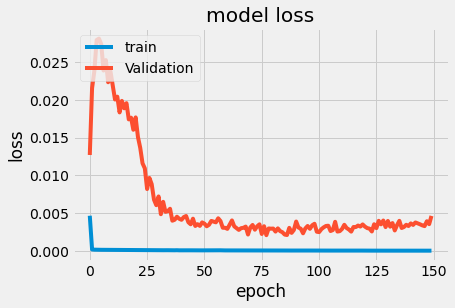

In [211]:
validation_curve(history2)

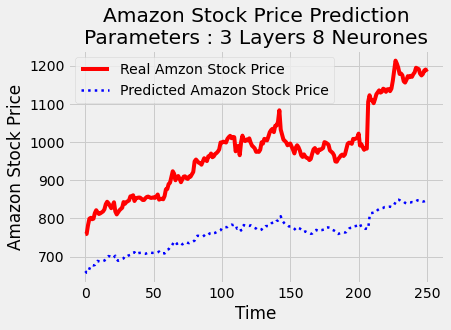

In [341]:
predicted_stock_price_scale2 = model2.predict(X_test)
predicted_stock_price2 = sc.inverse_transform(predicted_stock_price_scale2)
plot_predictions(test_set,predicted_stock_price2,"3 Layers 8 Neurones")

In [205]:
return_rmse(test_set,predicted_stock_price2)

The root mean squared error is 215.15572978837173.


#### Conclusion
On a clairement pas d'amélioration la learning curve nous montre plusieurs problèmes potentiel 
Un set de validation pas représentatif de notre dataset.
Passé 50 epoch la validation ne semble plus s'améliorer voir augmenter un peu sur la fin. 

### Model3: on ajoute des layers de Dropout pour essayer de corriger le précédent modèle. 

In [193]:
model3=Sequential()

model3.add(LSTM(units=8, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(units=8, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM (units=8))
model3.add(Dropout(0.2))
model3.add(Dense(units=1))

model3.compile(optimizer='adam',loss='mean_squared_error')

In [195]:
history3=model3.fit(X_train,y_train, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
60/60 [==============================] - 11s 184ms/step - loss: 0.0092 - val_loss: 0.0406
Epoch 2/150
60/60 [==============================] - 6s 96ms/step - loss: 0.0017 - val_loss: 0.0080
Epoch 3/150
60/60 [==============================] - 6s 94ms/step - loss: 0.0012 - val_loss: 0.0117
Epoch 4/150
60/60 [==============================] - 6s 93ms/step - loss: 9.6894e-04 - val_loss: 0.0162
Epoch 5/150
60/60 [==============================] - 5s 81ms/step - loss: 7.9603e-04 - val_loss: 0.0176
Epoch 6/150
60/60 [==============================] - 6s 92ms/step - loss: 7.6515e-04 - val_loss: 0.0205
Epoch 7/150
60/60 [==============================] - 5s 86ms/step - loss: 6.8427e-04 - val_loss: 0.0219
Epoch 8/150
60/60 [==============================] - 5s 82ms/step - loss: 6.6415e-04 - val_loss: 0.0200
Epoch 9/150
60/60 [==============================] - 5s 79ms/step - loss: 7.0613e-04 - val_loss: 0.0224
Epoch 10/150
60/60 [==============================] - 5s 80ms/step - loss:

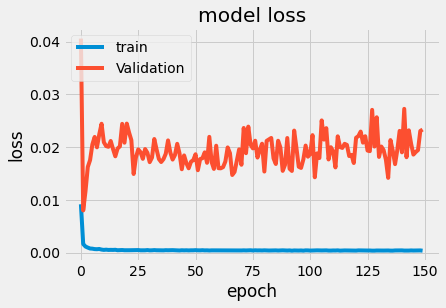

In [212]:
validation_curve(history3)

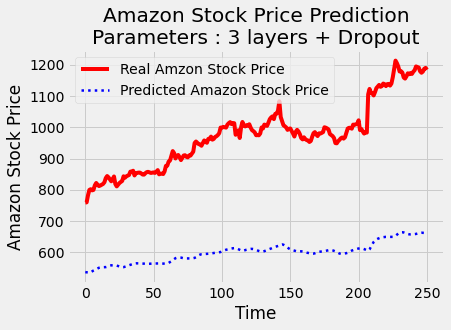

In [342]:
predicted_stock_price_scale3 = model3.predict(X_test)
predicted_stock_price3 = sc.inverse_transform(predicted_stock_price_scale3)
plot_predictions(test_set,predicted_stock_price3, "3 layers + Dropout")

In [214]:
return_rmse(test_set, predicted_stock_price3)

The root mean squared error is 379.9478657423257.


#### Conclusion
Les résultat avec le dropout on va le mettre à 0 pour la suite. 

### Model4: On augmente le nombre de neurone dans notre unique layers

In [199]:
model4=Sequential()
model4.add(LSTM(units=25))
model4.add(Dense(units=1))
model4.compile(optimizer='adam',loss='mean_squared_error')

In [200]:
history4=model4.fit(X_train,y_train, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
60/60 [==============================] - 4s 74ms/step - loss: 0.0115 - val_loss: 0.0158
Epoch 2/150
60/60 [==============================] - 2s 37ms/step - loss: 2.6457e-04 - val_loss: 0.0096A: 0s - loss:  - ETA: 0s - loss: 2.7373
Epoch 3/150
60/60 [==============================] - 2s 37ms/step - loss: 1.6377e-04 - val_loss: 0.0022
Epoch 4/150
60/60 [==============================] - 2s 39ms/step - loss: 1.2100e-04 - val_loss: 0.0014
Epoch 5/150
60/60 [==============================] - 2s 39ms/step - loss: 1.0185e-04 - val_loss: 0.0025
Epoch 6/150
60/60 [==============================] - 2s 40ms/step - loss: 9.4717e-05 - val_loss: 0.0041A: 0s - loss: 9.4402e
Epoch 7/150
60/60 [==============================] - 2s 38ms/step - loss: 9.2985e-05 - val_loss: 0.0036
Epoch 8/150
60/60 [==============================] - 2s 39ms/step - loss: 9.0976e-05 - val_loss: 0.0035
Epoch 9/150
60/60 [==============================] - 2s 34ms/step - loss: 8.8639e-05 - val_loss: 0.0038
Epoch 10

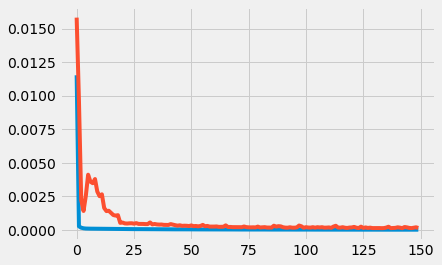

In [201]:
plt.plot(history4.history["loss"])
plt.plot(history4.history['val_loss'])

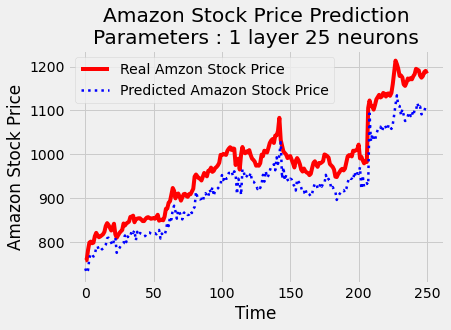

In [343]:
predicted_stock_price_scale4 = model4.predict(X_test)
predicted_stock_price4 = sc.inverse_transform(predicted_stock_price_scale4)
plot_predictions(test_set,predicted_stock_price4, "1 layer 25 neurons")

In [204]:
return_rmse(test_set, predicted_stock_price4)

The root mean squared error is 22.230658939998197.


#### Conclusion
On a clairement une amélioration par rapport au premier modèle on peut peut-être l'améliorer encore un peu

### Fonction predict

In [344]:
def predict_indicator(hist,model_,X_,y_reel, desc):
    validation_curve(hist)        
    predicted_stock_price_scale = model_.predict(X_)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price_scale)
    plot_predictions(y_reel,predicted_stock_price, desc)
    return_rmse(y_reel,predicted_stock_price)
    

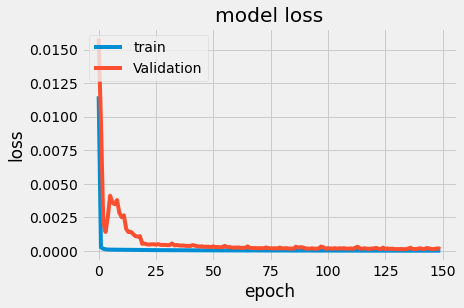

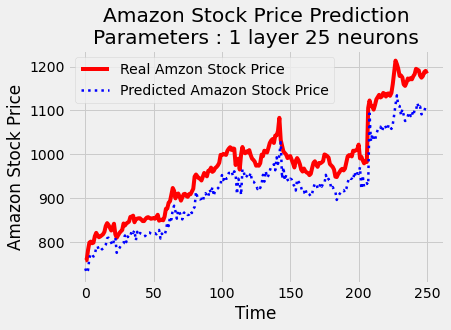

The root mean squared error is 55.284835439304345.


In [345]:
predict_indicator(history4,model4,X_test,test_set, "1 layer 25 neurons")

# Amplitude de temps: 7, 15, 60

In [262]:
#7 jours
X_train7,X_test7, y_train7, test_set7, sc7 = split_time_series(df_simple,"High",training_set,test_set,7)

#15 jours
X_train15,X_test15, y_train15, test_set15, sc15 = split_time_series(df_simple,"High",training_set,test_set,15)

#60 jours
X_train60,X_test60, y_train60, test_set60, sc60 = split_time_series(df_simple,"High",training_set,test_set,60)



(258, 1)
(266, 1)
(311, 1)


In [271]:
model7=Sequential()
model7.add(LSTM(units=25))
model7.add(Dense(units=1))
model7.compile(optimizer='adam',loss='mean_squared_error')
history7=model7.fit(X_train7,y_train7, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
61/61 [==============================] - 4s 69ms/step - loss: 0.0046 - val_loss: 6.1136e-04
Epoch 2/150
61/61 [==============================] - 1s 22ms/step - loss: 7.8486e-05 - val_loss: 0.0043
Epoch 3/150
61/61 [==============================] - 1s 21ms/step - loss: 4.7579e-05 - val_loss: 0.0035
Epoch 4/150
61/61 [==============================] - 2s 32ms/step - loss: 4.5746e-05 - val_loss: 0.0027
Epoch 5/150
61/61 [==============================] - 3s 43ms/step - loss: 4.4374e-05 - val_loss: 0.0018
Epoch 6/150
61/61 [==============================] - 2s 34ms/step - loss: 4.3660e-05 - val_loss: 9.7777e-04
Epoch 7/150
61/61 [==============================] - 2s 27ms/step - loss: 4.2927e-05 - val_loss: 7.1563e-04
Epoch 8/150
61/61 [==============================] - 1s 23ms/step - loss: 4.2315e-05 - val_loss: 3.9955e-04
Epoch 9/150
61/61 [==============================] - 1s 19ms/step - loss: 4.2188e-05 - val_loss: 3.6139e-04
Epoch 10/150
61/61 [============================

In [272]:
model15=Sequential()
model15.add(LSTM(units=25))
model15.add(Dense(units=1))
model15.compile(optimizer='adam',loss='mean_squared_error')
history15=model15.fit(X_train15,y_train15, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
61/61 [==============================] - 5s 76ms/step - loss: 0.0044 - val_loss: 0.0113
Epoch 2/150
61/61 [==============================] - 1s 19ms/step - loss: 1.0994e-04 - val_loss: 0.0046
Epoch 3/150
61/61 [==============================] - 1s 18ms/step - loss: 8.5966e-05 - val_loss: 0.0011
Epoch 4/150
61/61 [==============================] - 1s 21ms/step - loss: 7.8475e-05 - val_loss: 7.4429e-04
Epoch 5/150
61/61 [==============================] - 1s 22ms/step - loss: 7.1571e-05 - val_loss: 0.0011
Epoch 6/150
61/61 [==============================] - 2s 30ms/step - loss: 6.8523e-05 - val_loss: 0.0016
Epoch 7/150
61/61 [==============================] - 1s 22ms/step - loss: 6.6284e-05 - val_loss: 0.0032
Epoch 8/150
61/61 [==============================] - 1s 23ms/step - loss: 6.3817e-05 - val_loss: 0.0029
Epoch 9/150
61/61 [==============================] - 1s 21ms/step - loss: 6.5157e-05 - val_loss: 0.0035
Epoch 10/150
61/61 [==============================] - 1s 21ms/st

61/61 [==============================] - 1s 20ms/step - loss: 2.7990e-05 - val_loss: 2.0255e-04
Epoch 78/150
61/61 [==============================] - 1s 20ms/step - loss: 2.7004e-05 - val_loss: 1.6790e-04
Epoch 79/150
61/61 [==============================] - 1s 20ms/step - loss: 2.3866e-05 - val_loss: 2.0881e-04
Epoch 80/150
61/61 [==============================] - 1s 19ms/step - loss: 2.3330e-05 - val_loss: 2.4747e-04
Epoch 81/150
61/61 [==============================] - 1s 20ms/step - loss: 2.4193e-05 - val_loss: 2.7325e-04
Epoch 82/150
61/61 [==============================] - 1s 21ms/step - loss: 2.3966e-05 - val_loss: 3.2226e-04
Epoch 83/150
61/61 [==============================] - 1s 20ms/step - loss: 2.3807e-05 - val_loss: 1.6428e-04
Epoch 84/150
61/61 [==============================] - 1s 20ms/step - loss: 2.3748e-05 - val_loss: 2.0542e-04
Epoch 85/150
61/61 [==============================] - 1s 21ms/step - loss: 2.4348e-05 - val_loss: 1.7301e-04
Epoch 86/150
61/61 [============

In [273]:
model60=Sequential()
model60.add(LSTM(units=25))
model60.add(Dense(units=1))
model60.compile(optimizer='adam',loss='mean_squared_error')
history60=model60.fit(X_train60,y_train60, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
60/60 [==============================] - 6s 102ms/step - loss: 0.0010 - val_loss: 7.3433e-04
Epoch 2/150
60/60 [==============================] - 3s 54ms/step - loss: 6.1005e-05 - val_loss: 8.0695e-04
Epoch 3/150
60/60 [==============================] - 3s 53ms/step - loss: 5.5148e-05 - val_loss: 8.1686e-04
Epoch 4/150
60/60 [==============================] - 3s 52ms/step - loss: 5.3729e-05 - val_loss: 0.0015
Epoch 5/150
60/60 [==============================] - 3s 55ms/step - loss: 5.2992e-05 - val_loss: 0.0014
Epoch 6/150
60/60 [==============================] - 3s 54ms/step - loss: 5.1785e-05 - val_loss: 0.0014
Epoch 7/150
60/60 [==============================] - 3s 52ms/step - loss: 5.0690e-05 - val_loss: 0.0015
Epoch 8/150
60/60 [==============================] - 3s 54ms/step - loss: 5.0610e-05 - val_loss: 0.0012
Epoch 9/150
60/60 [==============================] - 3s 53ms/step - loss: 4.9618e-05 - val_loss: 0.0017
Epoch 10/150
60/60 [==============================] - 3

60/60 [==============================] - 4s 70ms/step - loss: 1.5220e-05 - val_loss: 1.6653e-04


### <font color=red>A ne pas faire</font>

Les modèles de deeplearning gardes les informations des précédents entrainements si on les rappelles. 
Ici on a réutiliser le model4 en pensant ne reprendre que l'architecture et les paramètre du model 
L'expérience qui suit nous montre que l'entrainement sur T=30 avait été conservé et utiliser pour ce nouvelle entrainement par ailleurs il est probable que mon précédent modèle à été fuck up par ce nouvelle entrainement. 

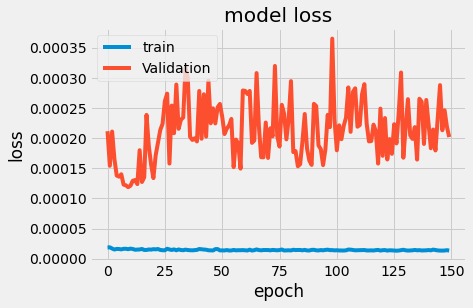

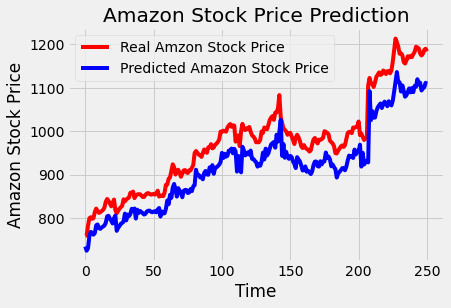

The root mean squared error is 57.523094196379596.


In [268]:
predict_indicator(history7,model4,X_test7,test_set7)

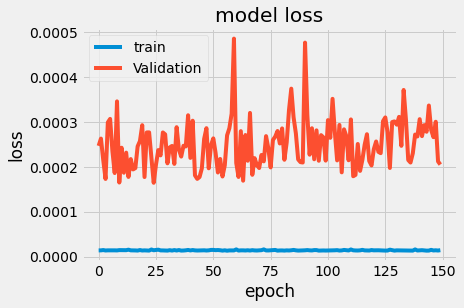

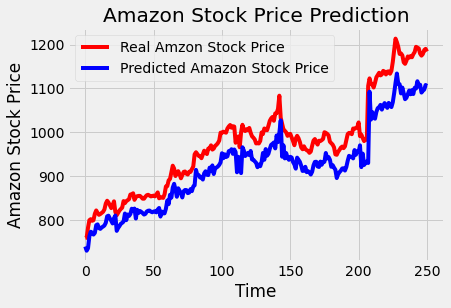

The root mean squared error is 56.16884304698502.


In [269]:
predict_indicator(history15,model4,X_test15,test_set15)

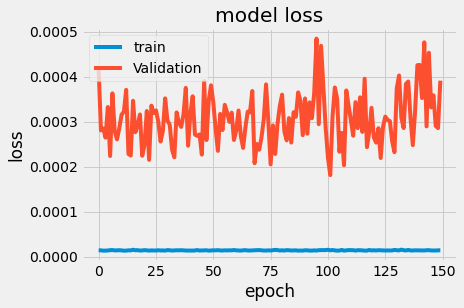

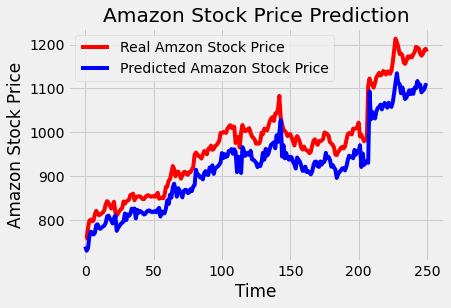

The root mean squared error is 55.271764054302466.


In [270]:
predict_indicator(history60,model4,X_test60,test_set60)

### <font color=red>||||</font>

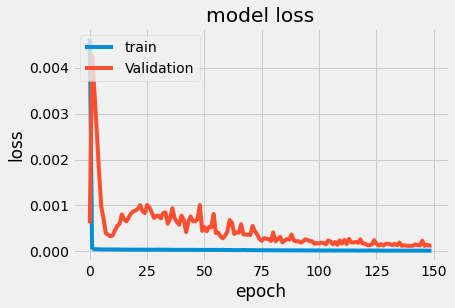

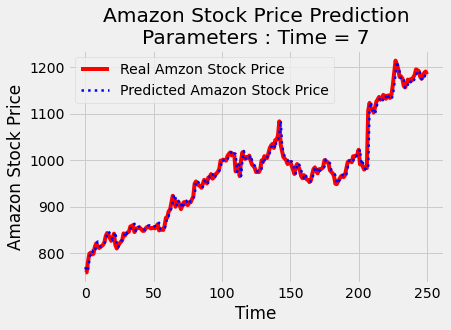

The root mean squared error is 12.514969661679102.


In [346]:
predict_indicator(history7,model7,X_test7,test_set7, "Time = 7")

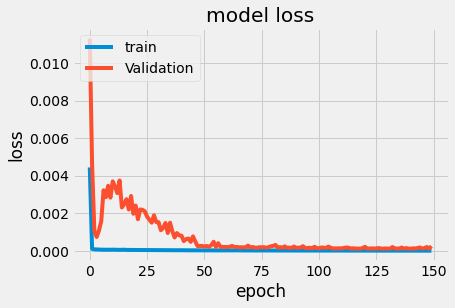

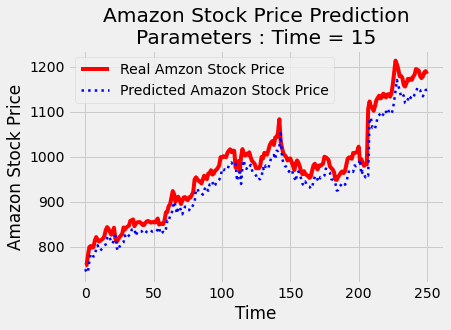

The root mean squared error is 31.4402954405679.


In [347]:
predict_indicator(history15,model15,X_test15,test_set15, "Time = 15")

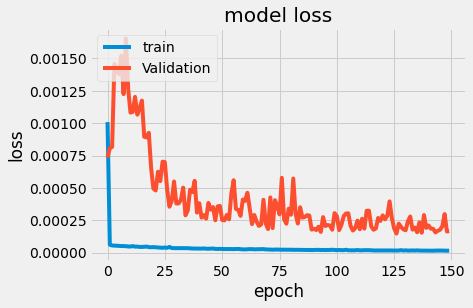

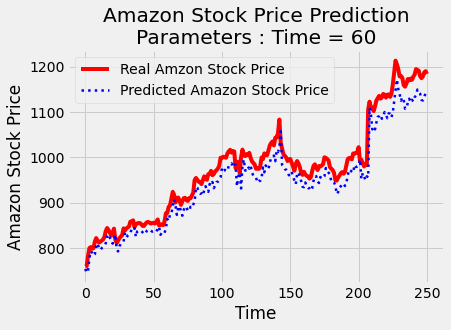

The root mean squared error is 32.548353773974824.


In [348]:
predict_indicator(history60,model60,X_test60,test_set60, "Time = 60")

### Model : 1 couche 50 neurones (T=30)

In [278]:
model50=Sequential()
model50.add(LSTM(units=50))
model50.add(Dense(units=1))
model50.compile(optimizer='adam',loss='mean_squared_error')
history50=model50.fit(X_train,y_train, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
60/60 [==============================] - 4s 73ms/step - loss: 0.0037 - val_loss: 0.0162
Epoch 2/150
60/60 [==============================] - 2s 37ms/step - loss: 8.9951e-05 - val_loss: 0.0033
Epoch 3/150
60/60 [==============================] - 2s 36ms/step - loss: 8.0405e-05 - val_loss: 0.0014
Epoch 4/150
60/60 [==============================] - 2s 36ms/step - loss: 7.3450e-05 - val_loss: 6.2961e-04
Epoch 5/150
60/60 [==============================] - 2s 36ms/step - loss: 7.3825e-05 - val_loss: 7.9973e-04
Epoch 6/150
60/60 [==============================] - 2s 36ms/step - loss: 7.5535e-05 - val_loss: 8.4974e-04
Epoch 7/150
60/60 [==============================] - 2s 39ms/step - loss: 6.8561e-05 - val_loss: 8.7738e-04
Epoch 8/150
60/60 [==============================] - 4s 60ms/step - loss: 7.1478e-05 - val_loss: 0.0010
Epoch 9/150
60/60 [==============================] - 3s 57ms/step - loss: 6.5129e-05 - val_loss: 8.7286e-0484e
Epoch 10/150
60/60 [=========================

60/60 [==============================] - 3s 53ms/step - loss: 1.6085e-05 - val_loss: 1.2659e-04


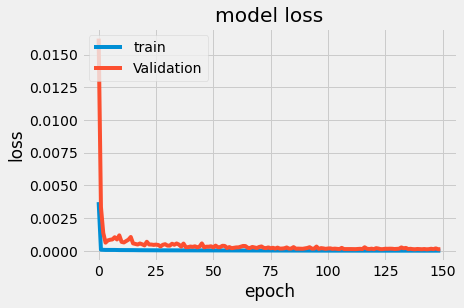

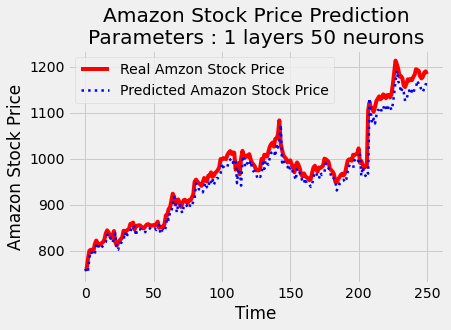

The root mean squared error is 21.41238143648983.


In [349]:
predict_indicator(history50,model50,X_test,test_set,"1 layers 50 neurons")

### Model : 1 couche 50 neurones (T=60)

In [283]:
model60_50=Sequential()
model60_50.add(LSTM(units=50))
model60_50.add(Dense(units=1))
model60_50.compile(optimizer='adam',loss='mean_squared_error')
history60_50=model60_50.fit(X_train60,y_train60, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
60/60 [==============================] - 2s 38ms/step - loss: 0.0040 - val_loss: 0.0186
Epoch 2/150
60/60 [==============================] - 2s 29ms/step - loss: 8.2931e-05 - val_loss: 0.0031
Epoch 3/150
60/60 [==============================] - 2s 29ms/step - loss: 7.4215e-05 - val_loss: 0.0011
Epoch 4/150
60/60 [==============================] - 2s 28ms/step - loss: 6.9295e-05 - val_loss: 5.9791e-04
Epoch 5/150
60/60 [==============================] - 2s 27ms/step - loss: 6.5523e-05 - val_loss: 5.8370e-04
Epoch 6/150
60/60 [==============================] - 2s 27ms/step - loss: 6.5844e-05 - val_loss: 7.5308e-04
Epoch 7/150
60/60 [==============================] - 2s 27ms/step - loss: 6.2782e-05 - val_loss: 7.3556e-04
Epoch 8/150
60/60 [==============================] - 2s 28ms/step - loss: 6.2108e-05 - val_loss: 0.0011
Epoch 9/150
60/60 [==============================] - 2s 26ms/step - loss: 6.1291e-05 - val_loss: 6.7982e-04
Epoch 10/150
60/60 [============================

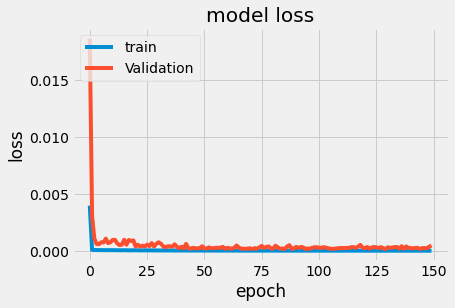

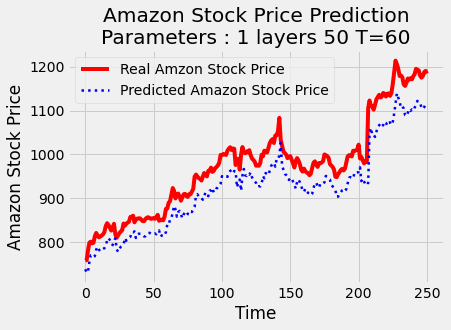

The root mean squared error is 51.950389814385225.


In [350]:
predict_indicator(history60_50,model60_50,X_test60,test_set60,"1 layers 50 T=60")

## Changer les paramètres

### Fonction d'activation

De base il faut comprendre qu'un LSTM aura par défaut une fonction d'activation "tanh" on va tenter de modifier celà avec une FC de la forme relu.

Pour l'instant notre meilleurs model est le model à 1 layers et 25 neurones et qui prédit à partir des 7 précédentes valeurs, afin de juger les résultats des changement de paramètre on va repartir sur notre modèle initial à 30 jours. 

In [285]:
model_relu=Sequential()
model_relu.add(LSTM(units=50,activation="relu"))
model_relu.add(Dense(units=1))
model_relu.compile(optimizer='adam',loss='mean_squared_error')
history_relu=model_relu.fit(X_train,y_train, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
60/60 [==============================] - 1s 21ms/step - loss: 0.0043 - val_loss: 0.2774
Epoch 2/150
60/60 [==============================] - 1s 15ms/step - loss: 6.8297e-05 - val_loss: 0.1020
Epoch 3/150
60/60 [==============================] - 1s 15ms/step - loss: 6.0462e-05 - val_loss: 0.0328
Epoch 4/150
60/60 [==============================] - 1s 15ms/step - loss: 5.5247e-05 - val_loss: 0.0229
Epoch 5/150
60/60 [==============================] - 1s 15ms/step - loss: 5.2427e-05 - val_loss: 0.0165
Epoch 6/150
60/60 [==============================] - 1s 17ms/step - loss: 5.1534e-05 - val_loss: 0.0142
Epoch 7/150
60/60 [==============================] - 1s 15ms/step - loss: 5.4382e-05 - val_loss: 0.0091
Epoch 8/150
60/60 [==============================] - 1s 15ms/step - loss: 5.4629e-05 - val_loss: 0.0072
Epoch 9/150
60/60 [==============================] - 1s 16ms/step - loss: 5.3137e-05 - val_loss: 0.0093
Epoch 10/150
60/60 [==============================] - 1s 15ms/step -

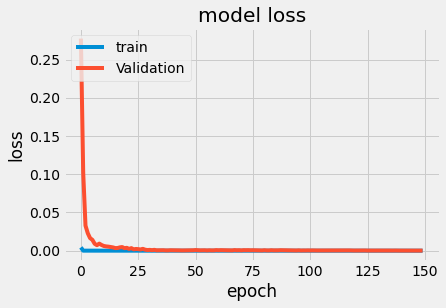

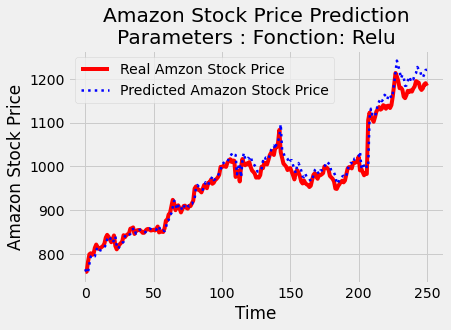

The root mean squared error is 17.69561388251466.


In [351]:
predict_indicator(history_relu, model_relu, X_test,test_set, "Fonction: Relu Neurons : 50")

In [303]:
model_relu2=Sequential()
model_relu2.add(LSTM(units=25,activation="relu"))
model_relu2.add(Dense(units=1))
model_relu2.compile(optimizer='adam',loss='mean_squared_error')
history_relu2=model_relu2.fit(X_train,y_train, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
60/60 [==============================] - 1s 17ms/step - loss: 0.0083 - val_loss: 0.0158
Epoch 2/150
60/60 [==============================] - 1s 12ms/step - loss: 8.3338e-05 - val_loss: 0.0192
Epoch 3/150
60/60 [==============================] - 1s 12ms/step - loss: 5.9398e-05 - val_loss: 0.0199
Epoch 4/150
60/60 [==============================] - 1s 12ms/step - loss: 5.7014e-05 - val_loss: 0.0201
Epoch 5/150
60/60 [==============================] - 1s 12ms/step - loss: 5.5212e-05 - val_loss: 0.0167
Epoch 6/150
60/60 [==============================] - 1s 12ms/step - loss: 5.5108e-05 - val_loss: 0.0208
Epoch 7/150
60/60 [==============================] - 1s 11ms/step - loss: 5.5133e-05 - val_loss: 0.0176
Epoch 8/150
60/60 [==============================] - 1s 13ms/step - loss: 5.3877e-05 - val_loss: 0.0180
Epoch 9/150
60/60 [==============================] - 1s 12ms/step - loss: 5.2753e-05 - val_loss: 0.0197
Epoch 10/150
60/60 [==============================] - 1s 13ms/step -

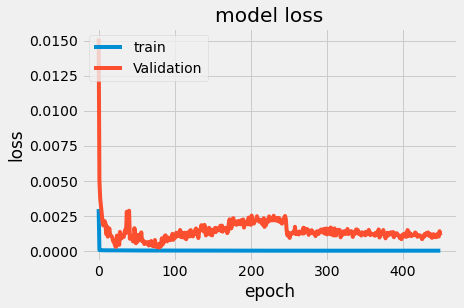

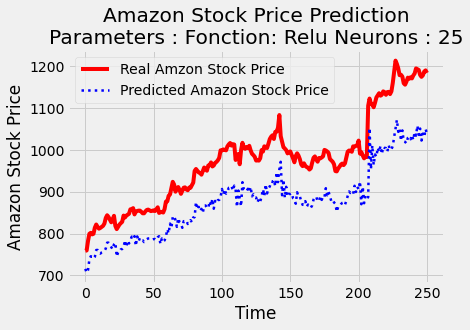

The root mean squared error is 100.10585117253702.


In [352]:
predict_indicator(history_relu2, model_relu2, X_test,test_set,"Fonction: Relu Neurons : 25")

### Optimizer

Jusque là nous sommes resté avec un optimizer fixer sur adam. Essayons de passer sur un autre optimizer qu'on a vu utiliser un peu avant le rmsprop

In [305]:
model_props=Sequential()
model_props.add(LSTM(units=25))
model_props.add(Dense(units=1))
model_props.compile(optimizer='rmsprop',loss='mean_squared_error')
history_props=model_props.fit(X_train,y_train, epochs=150,batch_size=32,validation_split=0.3)

Epoch 1/150
60/60 [==============================] - 1s 25ms/step - loss: 9.2182e-04 - val_loss: 9.0194e-04
Epoch 2/150
60/60 [==============================] - 1s 14ms/step - loss: 1.4315e-04 - val_loss: 0.0013
Epoch 3/150
60/60 [==============================] - 1s 13ms/step - loss: 1.2265e-04 - val_loss: 0.0010
Epoch 4/150
60/60 [==============================] - 1s 13ms/step - loss: 9.7761e-05 - val_loss: 7.6585e-04
Epoch 5/150
60/60 [==============================] - 1s 13ms/step - loss: 9.6152e-05 - val_loss: 0.0014
Epoch 6/150
60/60 [==============================] - 1s 13ms/step - loss: 9.9661e-05 - val_loss: 0.0012
Epoch 7/150
60/60 [==============================] - 1s 14ms/step - loss: 8.9141e-05 - val_loss: 7.8203e-04
Epoch 8/150
60/60 [==============================] - 1s 13ms/step - loss: 7.5139e-05 - val_loss: 0.0013
Epoch 9/150
60/60 [==============================] - 1s 13ms/step - loss: 8.2448e-05 - val_loss: 5.4648e-04
Epoch 10/150
60/60 [============================

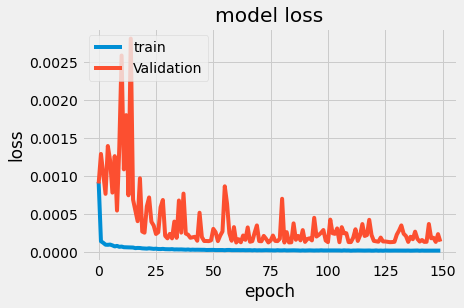

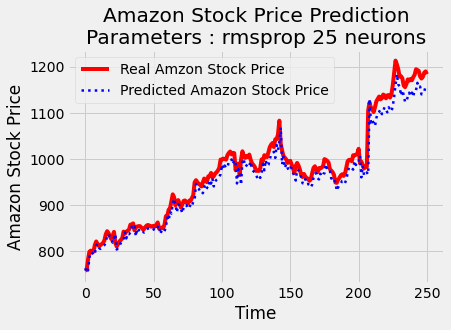

The root mean squared error is 22.4936954278882.


In [355]:
predict_indicator(history_props, model_props, X_test,test_set,"rmsprop 25 neurons")

### Epoch 

In [307]:
model_relu2=Sequential()
model_relu2.add(LSTM(units=25,activation="relu"))
model_relu2.add(Dense(units=1))
model_relu2.compile(optimizer='adam',loss='mean_squared_error')
history_relu2=model_relu2.fit(X_train,y_train, epochs=450,batch_size=32,validation_split=0.3)

Epoch 1/450
60/60 [==============================] - 1s 17ms/step - loss: 0.0030 - val_loss: 0.0152
Epoch 2/450
60/60 [==============================] - 1s 12ms/step - loss: 5.6708e-05 - val_loss: 0.0050
Epoch 3/450
60/60 [==============================] - 1s 12ms/step - loss: 5.0295e-05 - val_loss: 0.0037
Epoch 4/450
60/60 [==============================] - 1s 11ms/step - loss: 4.9783e-05 - val_loss: 0.0032
Epoch 5/450
60/60 [==============================] - 1s 12ms/step - loss: 4.7518e-05 - val_loss: 0.0027
Epoch 6/450
60/60 [==============================] - 1s 16ms/step - loss: 4.7368e-05 - val_loss: 0.0021
Epoch 7/450
60/60 [==============================] - 1s 13ms/step - loss: 4.6195e-05 - val_loss: 0.0018
Epoch 8/450
60/60 [==============================] - 1s 16ms/step - loss: 4.5416e-05 - val_loss: 0.0021
Epoch 9/450
60/60 [==============================] - 1s 12ms/step - loss: 4.3000e-05 - val_loss: 0.0021
Epoch 10/450
60/60 [==============================] - 1s 12ms/step -

60/60 [==============================] - 1s 12ms/step - loss: 1.5735e-05 - val_loss: 0.0015
Epoch 154/450
60/60 [==============================] - 1s 12ms/step - loss: 1.5398e-05 - val_loss: 0.0016
Epoch 155/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4606e-05 - val_loss: 0.0013
Epoch 156/450
60/60 [==============================] - 1s 11ms/step - loss: 1.4849e-05 - val_loss: 0.0016
Epoch 157/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4933e-05 - val_loss: 0.0016
Epoch 158/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4837e-05 - val_loss: 0.0015
Epoch 159/450
60/60 [==============================] - 1s 12ms/step - loss: 1.5100e-05 - val_loss: 0.0015
Epoch 160/450
60/60 [==============================] - 1s 12ms/step - loss: 1.5143e-05 - val_loss: 0.0016
Epoch 161/450
60/60 [==============================] - 1s 12ms/step - loss: 1.5192e-05 - val_loss: 0.0018
Epoch 162/450
60/60 [==============================] - 1s 11

Epoch 230/450
60/60 [==============================] - 1s 11ms/step - loss: 1.4549e-05 - val_loss: 0.0022
Epoch 231/450
60/60 [==============================] - 1s 11ms/step - loss: 1.4425e-05 - val_loss: 0.0025
Epoch 232/450
60/60 [==============================] - 1s 11ms/step - loss: 1.4267e-05 - val_loss: 0.0022
Epoch 233/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4661e-05 - val_loss: 0.0022
Epoch 234/450
60/60 [==============================] - 1s 11ms/step - loss: 1.4329e-05 - val_loss: 0.0022
Epoch 235/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4521e-05 - val_loss: 0.0024
Epoch 236/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4954e-05 - val_loss: 0.0022
Epoch 237/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4621e-05 - val_loss: 0.0021
Epoch 238/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4251e-05 - val_loss: 0.0023
Epoch 239/450
60/60 [=========================

Epoch 307/450
60/60 [==============================] - 1s 12ms/step - loss: 1.3747e-05 - val_loss: 0.0012
Epoch 308/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4482e-05 - val_loss: 0.0012
Epoch 309/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4352e-05 - val_loss: 0.0012
Epoch 310/450
60/60 [==============================] - 1s 12ms/step - loss: 1.3873e-05 - val_loss: 0.0011
Epoch 311/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4366e-05 - val_loss: 0.0016
Epoch 312/450
60/60 [==============================] - 1s 12ms/step - loss: 1.4483e-05 - val_loss: 0.0013
Epoch 313/450
60/60 [==============================] - 1s 13ms/step - loss: 1.3689e-05 - val_loss: 0.0011
Epoch 314/450
60/60 [==============================] - 1s 13ms/step - loss: 1.3871e-05 - val_loss: 0.0014
Epoch 315/450
60/60 [==============================] - 1s 12ms/step - loss: 1.7059e-05 - val_loss: 0.0013
Epoch 316/450
60/60 [=========================

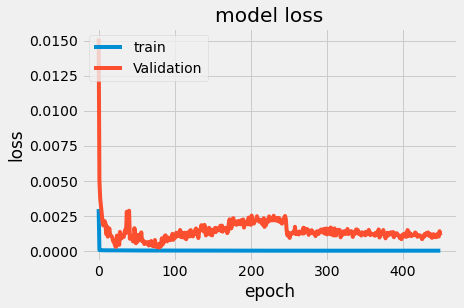

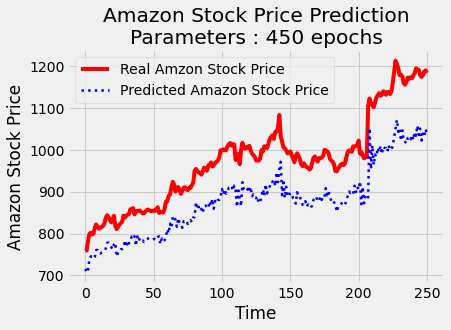

The root mean squared error is 100.10585117253702.


In [354]:
predict_indicator(history_relu2, model_relu2, X_test,test_set, "450 epochs")

## Portabilité ? 

In [356]:
df_apple=pd.read_csv("AAPL_2006-01-01_to_2018-01-01.csv",index_col="Date", parse_dates=['Date'])

In [357]:
df_apple

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL
...,...,...,...,...,...,...
2017-12-22,174.68,175.42,174.50,175.01,16349444,AAPL
2017-12-26,170.80,171.47,169.68,170.57,33185536,AAPL
2017-12-27,170.10,170.78,169.71,170.60,21498213,AAPL


Text(0.5, 1.0, 'Apple stock price')

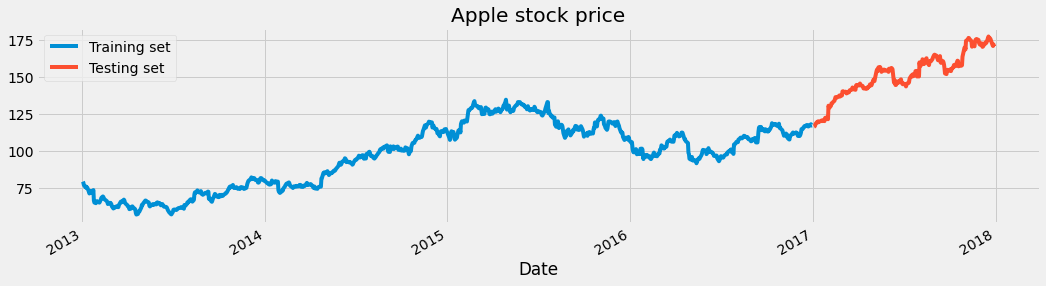

In [358]:
#Visualisation trainin_set et testing_set
df_apple["2013":"2016"].High.plot(figsize=(16,4), legend=True)
df_apple["2017":].High.plot(figsize=(16,4), legend=True)
plt.legend(["Training set","Testing set"])
plt.title('Apple stock price')

In [360]:
training_set_apple = df_simple[:'2016'].iloc[:,1:2].values
test_set_apple = df_simple['2017':].iloc[:,1:2].values

In [364]:
X_train_apple,X_test_apple,y_train_apple,test_set_apple, sc= split_time_series(df_apple,"High",training_set_apple,test_set_apple,7)

(258, 1)


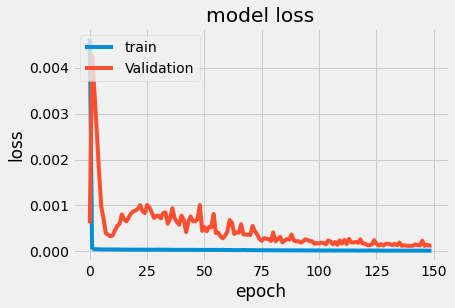

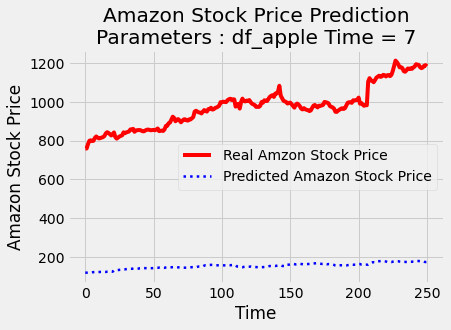

The root mean squared error is 826.8119709948397.


In [365]:
predict_indicator(history7,model7,X_test_apple,test_set_apple, "df_apple Time = 7")

Ouch portabilité 0...

In [1]:
model_relu3=Sequential()
model_relu3.add(LSTM(units=50,activation="relu"))
model_relu3.add(Dense(units=1))
model_relu3.compile(optimizer='adam',loss='mean_squared_error')
history_relu3=model_relu3.fit(X_train,y_train, epochs=5000,batch_size=32,validation_split=0.3)

NameError: name 'Sequential' is not defined